# COAMPS-TC Translation Demo

April, 2024

Jake Davis (davisjr@uw.edu)

## The challenge:

The aggregated COAMPS-TC forecasts occasionally deviate from the best track, assumed here to be the "truth", which can result in errors when querying positions (e.g., buoy locations) close to the center of the storm.  For example, in the image below, the buoy (yellow pentagon) is towards the outside of the high wind speed region of the storm relative to the COAMPS-TC fields (color scale), however, relative to the best track at this time (black dot), the buoy is near the eye.  This error will propagate when extracting wind speeds from COAMPS at the buoy's location in absolute lon-lat coordinates.  A solution is to determine the buoy's position relative to the storm's center on the best track, and then "shift" the buoy relative to the COAMPS-TC center. The shift must NOT place the buoy over the coast.

<figure>
    <img src="./figures/idalia_spotter_coamps_error_example.png" width="1000"/>
    <figcaption>Figure 1: The problem. </figcaption>
</figure>


<figure>
    <img src="./figures/idalia_spotter_coamps_error_example_solution.png" width="1000"/>
    <figcaption>Figure 2: A solution. </figcaption>
</figure>


## Setup

This example requires several external packages.  If you use Conda for package management, I have provided an `environment.yaml` file which can be used to create an environment called `coamps-tc-translation-demo` by running:

```shellscript  %console
$ conda env create -f environment.yml
```
in the terminal. Activate the environment using:
```shellscript
$ conda activate coamps-tc-translation-demo
```
(You can also just try to run it and download the required packages as needed.)

In [1]:
import os
import pickle
from typing import Tuple

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pyproj
import scipy
import toml
import xarray as xr  # also requires netcdf4 package
from pyproj import Transformer

import operations  # local module with some larger functions

File paths are stored in `config.toml`.  I'll provide an additional Google Drive link to the datasets used in the demo.  (I suggest copying the files to the `data` directory of this project.)

In [2]:
with open('config.toml', 'r') as f:
        config = toml.load(f)

## Read in datasets

### Drifters

Read in the aggregated drifter dataset.  This example will work with Spotters only, but it is applicable to the other drifters.

In [3]:
def concatenate_drifters(drifter_dict: dict) -> pd.DataFrame:
    """
    Concatenate a dictionary of individual drifter DataFrames into a single,
    multi-index DataFrame.  Drop the observations that do not contain waves
    (remove off-hour pressure and temperature observations).
    """
    drifter_df = (
        pd.concat(drifter_dict, names=['id', 'time'])
        .dropna(subset='energy_density')
    )
    return drifter_df

In [4]:
DRIFTER_DATA_PATH = config['dir']['drifter_data']

with open(DRIFTER_DATA_PATH, 'rb') as handle:
    drifter_data = pickle.load(handle)

spotters_df = concatenate_drifters(drifter_data['spotter'])

### COAMPS-TC

In [5]:
COAMPS_PATH = config['dir']['coamps']

coamps_ds = xr.open_dataset(COAMPS_PATH)
coamps_ds = coamps_ds.rename({
    'lon': 'longitude',
    'lat': 'latitude',
    'wind_u': 'u',
    'wind_v': 'v'
})
coamps_ws =  np.sqrt(coamps_ds['u'].values**2 + coamps_ds['v'].values**2)
coamps_ds['ws'] = (('time', 'latitude', 'longitude'), coamps_ws)


### IBTrACS

Load the International Best Track Archive for Climate Stewardship (IBTrACS) dataset directly from the database.

In [6]:
IBTRACS_BASE_URL = ('https://www.ncei.noaa.gov/data/international-best-'
                    'track-archive-for-climate-stewardship-ibtracs/'
                    'v04r00/access/csv/')
IBTRACS_BASE_CSV = f'ibtracs.last3years.list.v04r00.csv'
IBTRACS_URL = os.path.join(IBTRACS_BASE_URL, IBTRACS_BASE_CSV)
ibtracs_df = pd.read_csv(IBTRACS_URL, low_memory=False)

ibtracs_df = (ibtracs_df
    .query('NAME == "IDALIA"')
    .assign(ISO_TIME = lambda df: pd.to_datetime(df['ISO_TIME']))
    .set_index('ISO_TIME', drop=True)
    .assign(LAT = lambda df: df['LAT'].astype(np.float64))
    .assign(LON = lambda df: df['LON'].astype(np.float64))
)

## IBTrACS modifications

Cast the storm direction, latitude, and longitude fields to floats for computation.

In [7]:
def ibtracs_column_to_float(ibtracs_col):
    """ Convert a column of the IBTrACS DataFrame to float. """
    ibtracs_da_as_float = (ibtracs_col
                           .replace(' ', np.nan)
                           .apply(float))
    return ibtracs_da_as_float

In [8]:
ibtracs_df['STORM_DIR'] = ibtracs_column_to_float(ibtracs_df['STORM_DIR'])
ibtracs_df['LON'] = ibtracs_column_to_float(ibtracs_df['LON'])
ibtracs_df['LAT'] = ibtracs_column_to_float(ibtracs_df['LAT'])

## Drifter location relative to the best track

### Distance from eye

Compute the distance and heading from the eye of the storm to each buoy.  This requires interpolation of the best track data onto the buoy times.

In [9]:
def get_time_interpolation(interpolator, query_times):
    """ Query a Scipy `interp1d` interpolator at the given `query_times`."""
    # Requires conversion of datetimes to their numeric representation.
    numeric_query_times = pd.to_numeric(query_times)
    return interpolator(numeric_query_times)

def storm_distances(distance, bearing_deg):
    """ Determine the easting and northing relative to the storm center. """
    bearing_rad = np.deg2rad(bearing_deg)
    distance_east = distance * np.sin(bearing_rad)
    distance_north = distance * np.cos(bearing_rad)
    return distance_east, distance_north


Construct 1-dimensonal linear interpolation objects to interpolate the best track direction and latitude-longitude coords at new query times.  

**Note**: the direction must be unwrapped for correct interpolation.

In [10]:
coords = ibtracs_df[['LON', 'LAT']]
direction = ibtracs_df['STORM_DIR']
direction_unwrap = np.unwrap(direction, period=360)  # Required for interpolation between 360 and 0 deg.
times = pd.to_numeric(ibtracs_df.index.to_numpy())  # Numeric representation
coords_interpolator = scipy.interpolate.interp1d(times, coords, fill_value=np.nan, axis=0)
direction_interpolator = scipy.interpolate.interp1d(times, direction_unwrap, fill_value=np.nan, axis=0)

Add the interpolated columns to the buoy DataFrame.  These will be used to compute the distance and heading.

**Note**: since we are interpolating the storm position at each buoy time, and since the buoys report at different times within the hour, translation may result in a different buoy array shape.  This is because they are adjusted to different storm centers as the storm translates over the hour.

In [11]:
storm_positions = get_time_interpolation(coords_interpolator, spotters_df.index.get_level_values(level='time'))
spotters_df['storm_longitude'], spotters_df['storm_latitude'] = storm_positions.T  # Requires tranposition

storm_headings = get_time_interpolation(direction_interpolator, spotters_df.index.get_level_values(level='time'))
spotters_df['storm_heading'] = storm_headings.T % 360

Calculate the distance and bearing from the storm to the buoy (great circle distance).

In [12]:
spotters_df['storm_distance'], spotters_df['storm_back_bearing'] \
    = operations.great_circle_pairwise(
        longitude_a=spotters_df['storm_longitude'],
        latitude_a=spotters_df['storm_latitude'],
        longitude_b=spotters_df['longitude'],
        latitude_b=spotters_df['latitude']
    )

spotters_df['storm_distance_east'], spotters_df['storm_distance_north'] \
    = storm_distances(
        distance=spotters_df['storm_distance'],
        bearing_deg=spotters_df['storm_back_bearing']
    )

## COAMPS-TC local grid

To facilitate shifting the buoy relative to the COAMPS-TC center, the COAMPS-TC longitude-latitude grids will be transformed to a local x-y grid.  This grid is measured in distance units (m) and has its origin at the minimum pressure.  It is only valid near the origin (not hundreds of km away).

The transformation will be performed with a Transverse Mercator projection using the `pyproj` package (https://pyproj4.github.io/pyproj/stable/).

In [13]:
def localize_coamps_grid(
    longitude: np.ndarray,
    latitude: np.ndarray,
    pressure: np.ndarray
) -> Tuple[np.ndarray, np.ndarray, float, float]:
    """Localize a COAMPS-TC grid defined in `longitude` and `latitude` to a
    cartesian coordinate system centered at the minimum value of `pressure`.

    Args:
        longitude (np.ndarray): longitude array with shape (x,)
        latitude (np.ndarray):  latitude array with shape (y,)
        pressure (np.ndarray): pressure array with shape (x,y)

    Returns:
        Tuple: meshed x- and y-grids with shape (x,y) and the coordinates
        at the xy-origin (coordinates of the the minimum pressure).
    """
    longitude_grid, latitude_grid = np.meshgrid(longitude, latitude)
    origin_indices = np.unravel_index(pressure.argmin(), pressure.shape)
    origin = (longitude_grid[origin_indices], latitude_grid[origin_indices])
    x_grid, y_grid = lonlat_to_xy(longitude_grid, latitude_grid, origin)
    return x_grid, y_grid, origin[0], origin[1]


def lonlat_to_xy(
    longitude: np.ndarray,
    latitude: np.ndarray,
    origin: Tuple
) -> Tuple[np.ndarray, np.ndarray]:
    """Transform a longitude-latitude grid to a cartesian coordinate system.

    Transform a longitude-latitude grid to a local cartesian coordinate
    system using a Transverse Mercator projection. Inputs should have shape
    `(x,y)` where `x` is the number of longitudes and `y` is the number of
    latitudes.  The `origin` is a tuple containing the longitude and latitude
    which define the center of the local grid (i.e., 0, 0), respectively.
    Returns an x-y meshgrid in meters.

    Note: Assumes a WGS84 datum and ellipsoid.

    Args:
        longitude (np.ndarray): longitude meshgrid with shape (x,y)
        latitude (np.ndarray):  latitude meshgrid with shape (x,y)
        origin (Tuple): longitude and latitude which define the origin of the
            local grid as (longitude_0, latitude_0).

    Returns:
        Tuple[np.ndarray, np.ndarray]: meshed x- and y-grids each with
            shape (x,y) and units of meters.
    """
    transformer = lonlat_tmerc_transformer(origin)
    x_grid, y_grid = transformer.transform(longitude, latitude)
    return x_grid, y_grid


def lonlat_tmerc_transformer(origin: Tuple) -> pyproj.Transformer:
    """Initialize a pyproj Transformer to convert longitude and latitude to xy.

    Initialize and return a pyproj Transformer object which converts longitude
    and latitude arrays to a local xy-coordinate system centered on `origin`
    using a Transverse Mercator (re)projection. The `origin` is a tuple
    containing the longitude and latitude which define the center of the local
    grid (i.e., 0, 0), respectively.

    Note: Assumes a 'WGS84' datum and ellipsoid.

    Args:
        origin (Tuple): longitude and latitude which define the origin of the
            local grid as (longitude_0, latitude_0).

    Returns:
        pyproj.Transformer: a 'latlong' to 'tmerc' transformer object.
    """
    proj_from = pyproj.Proj(proj='latlong', datum='WGS84')
    proj_to = pyproj.Proj(proj='tmerc', lon_0=origin[0], lat_0=origin[1], ellps='WGS84', preserve_units=True)
    return Transformer.from_proj(proj_from=proj_from, proj_to=proj_to)


Apply the transformation to each timestep in the COAMPS-TC dataset using `xr.apply_ufunc`.

(If you are unfamiliar with apply_ufunc, a loop over time also works.  More here: https://docs.xarray.dev/en/stable/examples/apply_ufunc_vectorize_1d.html)

In [14]:
coamps_ds['x'], coamps_ds['y'], coamps_ds['x-center'], coamps_ds['y-center']\
    = xr.apply_ufunc(
    localize_coamps_grid,
    coamps_ds.longitude,
    coamps_ds.latitude,
    coamps_ds.mslp,
    input_core_dims=[["longitude"], ["latitude"], ["latitude", "longitude"]],
    output_core_dims=[["latitude", "longitude"], ["latitude", "longitude"], [], []],
    vectorize=True,
)

# Update attributes.
coamps_ds['x'].attrs['long_name'] = 'x-distance from minimum pressure'
coamps_ds['x'].attrs['units'] = 'm'
coamps_ds['y'].attrs['long_name'] = 'x-distance from minimum pressure'
coamps_ds['y'].attrs['units'] = 'm'
coamps_ds['x-center'].attrs['long_name'] = 'longitude of minimum pressure'
coamps_ds['y-center'].attrs['long_name'] = 'latitude of minimum pressure'

Plot the result at a single timestep.

/var/folders/5k/tj9m5nbs0rb__4sp5qh876yc0000gn/T/ipykernel_46905/1429787039.py:20: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  pcm = ax.pcolormesh(


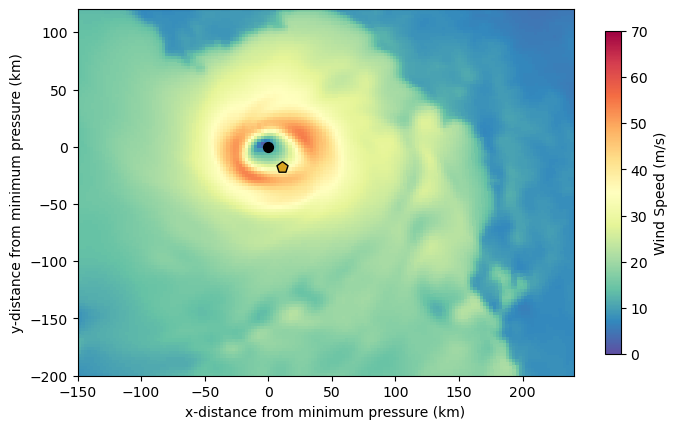

In [15]:
datetime = pd.Timestamp('2023-08-30T08:00')

spotter_marker_kwargs = {
    'color': 'goldenrod',
    'edgecolor': 'k',
    's': 70,
    'marker': 'p',
    'zorder': 5,
}
coamps_wind_plot_kwargs = dict(
    vmin=0,
    vmax=70,
    cmap='Spectral_r',
    zorder=1,
)

fig, ax = plt.subplots(figsize=(8, 6))

# Plot COAMPS-TC wind speeds and a dot at the origin.
pcm = ax.pcolormesh(
    coamps_ds.sel(time=datetime)['x'] * 10**(-3),  # convert to km
    coamps_ds.sel(time=datetime)['y'] * 10**(-3),
    coamps_ds.sel(time=datetime)['ws'],
    **coamps_wind_plot_kwargs
)
ax.scatter(0, 0, color='k', s=50,)

# Plot Spotters. Use a time slice since reporting times vary within the hour.
time_slice = slice(datetime.tz_localize('UTC'),
                   datetime.tz_localize('UTC')+pd.Timedelta('1h'))
ax.scatter(
    spotters_df.loc['SPOT-30103D'][time_slice]['storm_distance_east'],
    spotters_df.loc['SPOT-30103D'][time_slice]['storm_distance_north'],
    **spotter_marker_kwargs,
)

ax.set_xlim([-150, 240])
ax.set_ylim([-200, 120])
ax.set_xlabel('x-distance from minimum pressure (km)')
ax.set_ylabel('y-distance from minimum pressure (km)')
ax.set_aspect(0.9)  # attemping to match aspect ratio of lon-lat figure (1deg:1deg)
fig.colorbar(pcm, ax=ax, label='Wind Speed (m/s)', shrink=0.7)

Which compares well with the expected result:

<figure>
    <img src="./figures/idalia_spotter_coamps_error_example_solution.png" width="850"/>
</figure>

**Note**: the land appears resolved in the first plot (with the shifted buoy) since the COAMPS-TC winds are lower, but it is also shifted relative to reality!  Be careful of the coast.

Localizing the longitude and latitude grid to Cartesian coordinates (the previous step) produces irregular xy-grids. Here I demonstrate an additional step which interpolates the wind field onto a regular (rectangular) grid and stored in a new Dataset, `coamps_xy_ds`.

In [16]:
def regrid_irregular_field(field_irr, x_irr, y_irr, x_reg, y_reg):
    """Interpolate a field defined at irregular points onto a rectangular grid.

    Args:
        field_irr (np.ndarray): field at irregular points with shape (m, n)
        x_irr (np.ndarray): irregular x-coordinates with shape (m, n)
        y_irr (np.ndarray): irregular y-coordinates with shape (m, n)
        x_reg (np.ndarray): regular x-coordinates with shape (x)
        y_reg (np.ndarray): regular y-coordinates with shape (y)

    Returns:
        np.ndarray: field interpolated onto the regular grid with shape (x, y).
    """
    x_grid, y_grid = np.meshgrid(x_reg, y_reg)
    points_irr = np.c_[x_irr.ravel(), y_irr.ravel()]
    field_reg = scipy.interpolate.griddata(points_irr,
                                           field_irr.ravel(),
                                           (x_grid, y_grid),
                                           method='linear')
    return field_reg


(The next step may take a couple of minutes.)

In [17]:
# Create x and y arrays which will define the rectangular grid (in units of m).
# The grid is centered on the storm and aligned with north.  The goal is to
# limit distortion and achieve similar resolution to the original grid, 0.025
# degrees of latitude (about 2775 m).
x_arr = np.arange(-750*10**3, 750*10**3, 2775)  # 0.025 deg
y_arr = np.arange(-750*10**3, 750*10**3, 2775)

# Initialize the Dataset.  Variables will be added after.
coamps_xy_ds = xr.Dataset(
    coords=dict(
        time=coamps_ds['time'],
        x=(["x"], x_arr),
        y=(["y"], y_arr),
    ),
    attrs=dict(description="Storm-relative COAMPS-TC fields."),
)

# Interpolate the wind field magnitude and components and store in the Dataset.
for field in ['ws', 'u', 'v']:
    coamps_xy_ds[field] = xr.apply_ufunc(
        regrid_irregular_field,
        coamps_ds[field],
        coamps_ds['x'],
        coamps_ds['y'],
        x_arr,
        y_arr,
        input_core_dims=[["latitude", "longitude"],
                         ["latitude", "longitude"],
                         ["latitude", "longitude"],
                         ["x"],
                         ["y"]],
        output_core_dims=[["x", "y"]],
        exclude_dims=set(("x", "y")),  # dimensions allowed to change size.
        vectorize=True,
    )


Again, plotting the result at a single timestep (it should look the same as above)

In [18]:
def plot_local_coamps_grid(
    coamps_ds: xr.Dataset,
    field_var: str,
    x_var: str = 'x',
    y_var: str = 'y',
    rescale: float = 1*10**(-3),  # m to km
    ax=None,
    **kwargs,
):
    """ Plot COAMPS-TC field on a localized, regular grid. """
    x = coamps_ds[x_var].values * rescale
    y = coamps_ds[y_var].values * rescale
    field = coamps_ds[field_var].values
    X, Y = np.meshgrid(x, y)
    return ax.pcolormesh(X, Y, field, **kwargs)

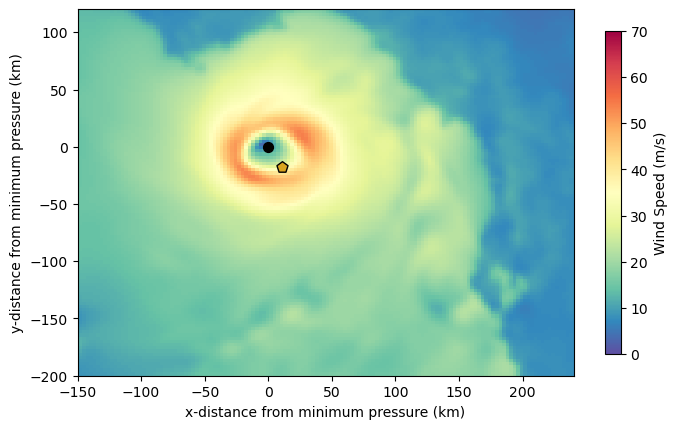

In [19]:
datetime = pd.Timestamp('2023-08-30T08:00')

fig, ax = plt.subplots(figsize=(8, 6))

# Plot COAMPS-TC wind speeds and a dot at the origin.
pcm = plot_local_coamps_grid(
    coamps_xy_ds.sel(time=datetime),
    field_var='ws',
    ax=ax,
    **coamps_wind_plot_kwargs,
)
ax.scatter(0, 0, color='k', s=50,)

# Plot Spotters. Use a time slice since reporting times vary within the hour.
time_slice = slice(datetime.tz_localize('UTC'),
                   datetime.tz_localize('UTC')+pd.Timedelta('1h'))
ax.scatter(
    spotters_df.loc['SPOT-30103D'][time_slice]['storm_distance_east'],
    spotters_df.loc['SPOT-30103D'][time_slice]['storm_distance_north'],
    **spotter_marker_kwargs,
)
ax.set_xlim([-150, 240])
ax.set_ylim([-200, 120])
ax.set_xlabel('x-distance from minimum pressure (km)')
ax.set_ylabel('y-distance from minimum pressure (km)')
ax.set_aspect(0.9)  # attemping to match aspect ratio of lon-lat figure (1deg:1deg)
fig.colorbar(pcm, ax=ax, label='Wind Speed (m/s)', shrink=0.7)

## Drifter location relative to COAMPS-TC

Now all that remains is to colocate the Spotters and COAMPS-TC data.  I'll use the function below to extract the wind speed, but any function to extract data at the buoy coordinates will work.  This might also be used to extract and compare other metrics such as significant wave height from a model driven by the COAMPS-TC winds.

In [20]:
TEMPORAL_TOLERANCE = np.timedelta64(60, 'm')

spotter_ids = spotters_df.index.get_level_values(level=0).unique()  # get ids
for spot_id in spotter_ids:
    for field in ['ws', 'u', 'v']:
        spotters_df.loc[spot_id, field] = operations.match_model_and_buoy_by_interpolation(
            buoy_time=spotters_df.loc[spot_id].index.to_numpy(dtype='datetime64[m]'),
            buoy_longitude=spotters_df.loc[spot_id]['storm_distance_east'].values,
            buoy_latitude=spotters_df.loc[spot_id]['storm_distance_north'].values,
            model_time=np.array(coamps_xy_ds['time'].values, dtype='datetime64[m]'),
            model_field=coamps_xy_ds[field].values,
            model_longitude=coamps_xy_ds['x'].values * 10**(-3),  # convert to km
            model_latitude=coamps_xy_ds['y'].values * 10**(-3),
            temporal_tolerance=TEMPORAL_TOLERANCE,
            bounds_error=False,
        )

For comparison, extract the wind speed using the native longitude-latitude grid:

In [21]:
SUFFIX = '_lon_lat'

spotter_ids = spotters_df.index.get_level_values(level=0).unique()
for spot_id in spotter_ids:
    for field in ['ws', 'u', 'v']:
        spotters_df.loc[spot_id, field + SUFFIX] = operations.match_model_and_buoy_by_interpolation(
            buoy_time=spotters_df.loc[spot_id].index.to_numpy(dtype='datetime64[m]'),
            buoy_longitude=spotters_df.loc[spot_id]['longitude'].values,
            buoy_latitude=spotters_df.loc[spot_id]['latitude'].values,
            model_time=np.array(coamps_ds['time'].values, dtype='datetime64[m]'),
            model_field=coamps_ds[field].values,
            model_longitude=coamps_ds['longitude'].values,
            model_latitude=coamps_ds['latitude'].values,
            temporal_tolerance=TEMPORAL_TOLERANCE,
            bounds_error=False,
        )

Plotting both colocated wind speeds, we observe substantial differences when the Spotter is nearest to the eye.  The effect is particularly severe at the datetime shown above (2023-08-30T08:00Z), as shown by the dashed line.

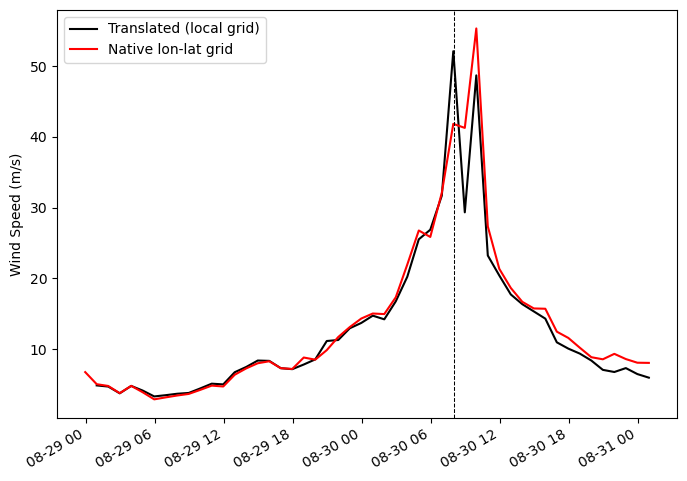

In [22]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(
    spotters_df.loc['SPOT-30103D'].index,
    spotters_df.loc['SPOT-30103D']['ws'],
    color='k',
    label='Translated (local grid)'
)
ax.plot(
    spotters_df.loc['SPOT-30103D'].index,
    spotters_df.loc['SPOT-30103D']['ws_lon_lat'],
    color='r',
    label='Native lon-lat grid'
)
ax.axvline(datetime, color='k', linestyle='--', linewidth=0.75)
ax.legend()
ax.set_ylabel('Wind Speed (m/s)')
fig.autofmt_xdate()

## Additional Note

When calculating the buoy northing and easting relative to the storm center we used a simple transformation and trigonometry.  We could have also used the `pyproj`-based functions that we used to transform the COAMPS grids.

In [23]:
def get_drifter_storm_coords(
    longitude: np.ndarray,
    latitude: np.ndarray,
    storm_longitude: np.ndarray,
    storm_latitude: np.ndarray,
) -> Tuple[np.ndarray, np.ndarray]:
    """
    Get the x- and y-distance from a drifter to the storm center in cartesian
    coordinates using a trnasverse mercator projection.

    Args:
        longitude (np.ndarray): drifter longitudes.
        latitude (np.ndarray): drifter latitudes.
        storm_longitude (np.ndarray): storm center longitude for (x-origin).
        storm_latitude (np.ndarray):  storm center latitude for (y-origin).

    Returns:
        Tuple[np.ndarray, np.ndarray]: x- and y-distance from the storm center
            in kilometers.
    """
    origin = (storm_longitude, storm_latitude)
    x_distance_m, y_distance_m = lonlat_to_xy(
        longitude=longitude,
        latitude=latitude,
        origin=origin)
    x_distance_km = x_distance_m * 10**(-3)
    y_distance_km = y_distance_m * 10**(-3)
    return x_distance_km, y_distance_km


In [24]:
spotters_df[['storm_distance_east_2', 'storm_distance_north_2']] = spotters_df.apply(
    lambda df: get_drifter_storm_coords(
        longitude=df['longitude'],
        latitude=df['latitude'],
        storm_longitude=df['storm_longitude'],
        storm_latitude=df['storm_latitude'],
    ),
    result_type='expand',
    axis=1,
)

The result is approximately the same as before:

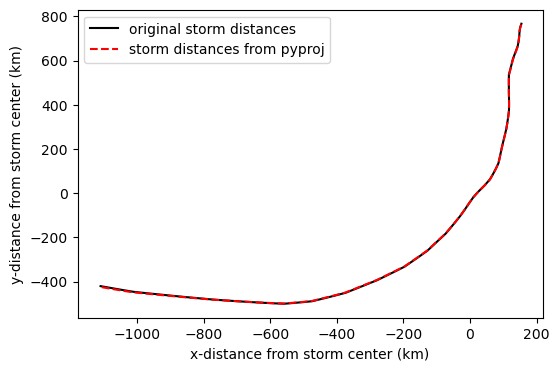

In [25]:
fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(
    spotters_df.loc['SPOT-30103D']['storm_distance_east'],
    spotters_df.loc['SPOT-30103D']['storm_distance_north'],
    color='k',
    label='original storm distances'
)
ax.plot(
    spotters_df.loc['SPOT-30103D']['storm_distance_east_2'],
    spotters_df.loc['SPOT-30103D']['storm_distance_north_2'],
    color='r',
    linestyle='--',
    label='storm distances from pyproj'

)
ax.set_ylabel('y-distance from storm center (km)')
ax.set_xlabel('x-distance from storm center (km)')
ax.legend()

Using the `pyproj` method might be preferred when transforming and shifting an entire model grid (as is done to transform the COAMPS data).